In [16]:
import sys
import os
sys.path.append('../src')
from main import LitClassifier

from model import ImgModel
from data import WavDatset
from trans import get_transforms
import pandas as pd
import numpy as np
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import trainer
from torch.nn import functional as F
from typing import Optional


import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
BASE_DIR = '../data/'
TRAIN_PATH = os.path.join(BASE_DIR, 'train_dataset')
TEST_PATH = os.path.join(BASE_DIR, 'test_dataset')

In [3]:
def make_test_dataloader():
    # Test Dataloader
    test_df = pd.read_csv('../data/sample_submission.csv')#[:100]
    test_dataset = WavDatset(test_df, trans=get_transforms(data='test'), is_train=False) #  images=test_images,
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10)
    return test_dataloader


In [12]:
class LitClassifier(pl.LightningModule):
    """
    >>> LitClassifier(Backbone())  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    LitClassifier(
      (backbone): ...
    )
    """

    def __init__(
        self,
        scale_list = [0.25, 0.5], # 0.125, 
        backbone: Optional[ImgModel] = None,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])
        if backbone is None:
            backbone = ImgModel()
        self.backbone = backbone

    def forward(self, batch):
        out = self.backbone.backbone.forward_features(batch)
        out = self.backbone.pool(out)
        out = self.backbone.fc(out[:,:,0,0])
        return out

In [13]:
weight_file = 'epoch=27-val_acc=0.5149_fold_0.ckpt' 
loade_model_path = f'../src/model/{weight_file}'
model = LitClassifier()
model = model.load_from_checkpoint(loade_model_path).cuda().eval()

In [14]:


test_dataloader = make_test_dataloader()
pred_list = list()
with torch.no_grad():
    for i, x in enumerate(tqdm(test_dataloader)):
        pred = model(x.cuda())
        pred = pred.detach().cpu()#.sigmoid()
        pred = torch.argmax(pred, dim=1)
        pred_list.append(pred)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.37it/s]


In [15]:
pred = torch.cat(pred_list)

<AxesSubplot:ylabel='count'>

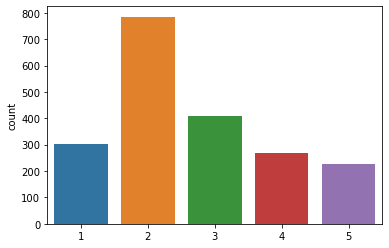

In [20]:
sns.countplot(pred.numpy())

In [23]:

# print(pred)
sub = pd.read_csv('../data/sample_submission.csv')
sub['age_'] = pred.numpy() + 1
sub.to_csv('../sub/eff_128size.csv', index=False)

In [24]:
sub

,file_name,age_
0,1,4
1,10,3
2,100,5
3,1000,3
4,1001,4
...,...,...
1985,995,5
1986,996,2
1987,997,3
1988,998,6
